# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

,metric
總報酬率,151.36
年化報酬率,期間過短，不適用
日報酬率,9.2613
最大回撤,-48.94
交易次數,10
勝率,80.0
平均持有K棒數,39.7
平均每筆報酬率,12.15


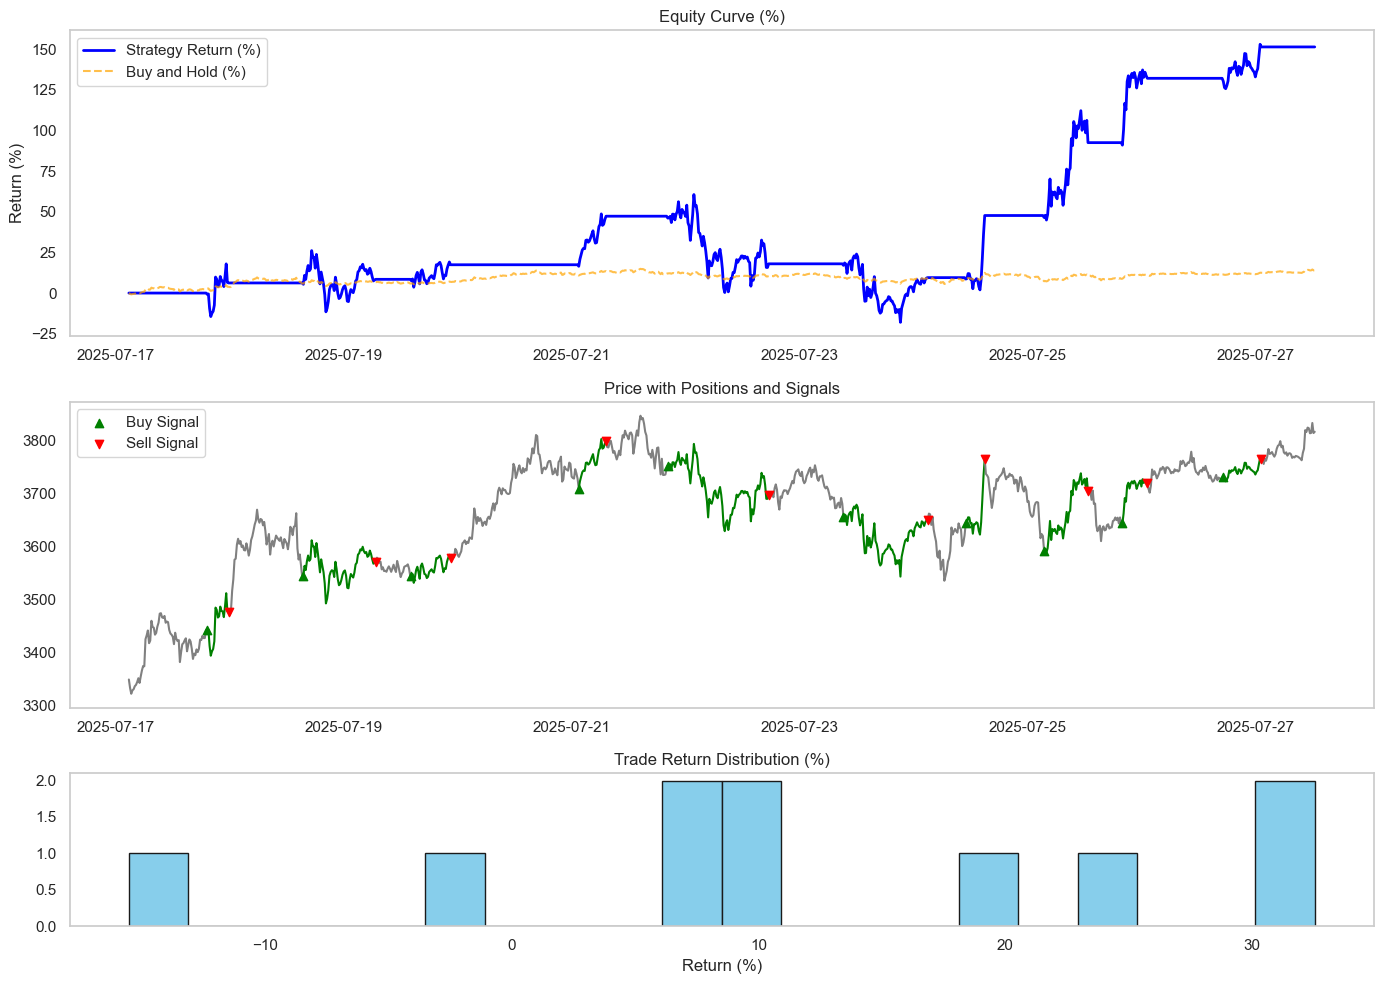

In [14]:
from Technicalindicatorstrategy import stochastic_range_bound,vegas,vegas_adx,sma
from datetime import datetime, timedelta
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd


df_signals = sma.get_signals('ETHUSDT','15m',datetime.now(),1000,n1 = 60, n2 = 35)

result = backtest_signals(
    df_signals,
    initial_capital=33, #1000台幣
    fee_rate = 0.0004,# 合約（用市價單）
    leverage=10, 
    allow_short=False)

display(pd.DataFrame(result['metric'],index=['metric']).T)
plot_backtest_result(result['fig'])


In [15]:
df_signals['signal'].value_counts()

signal
 0    980
 1     10
-1     10
Name: count, dtype: int64

In [16]:
import finlab_crypto

  0%|          | 0/324 [00:00<?, ?it/s]

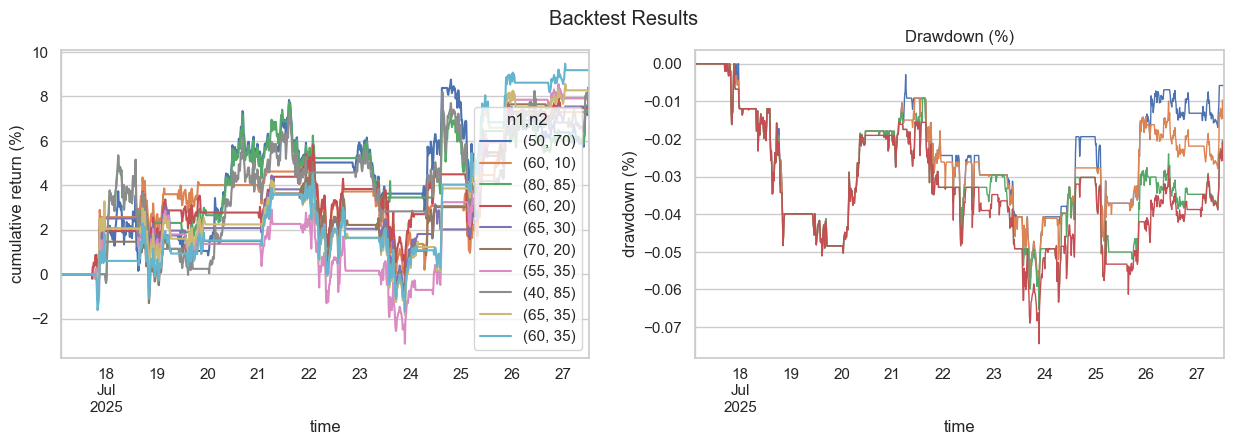

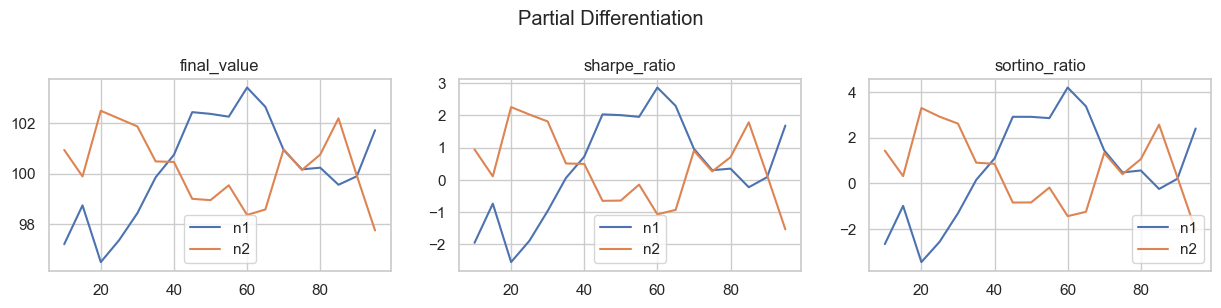

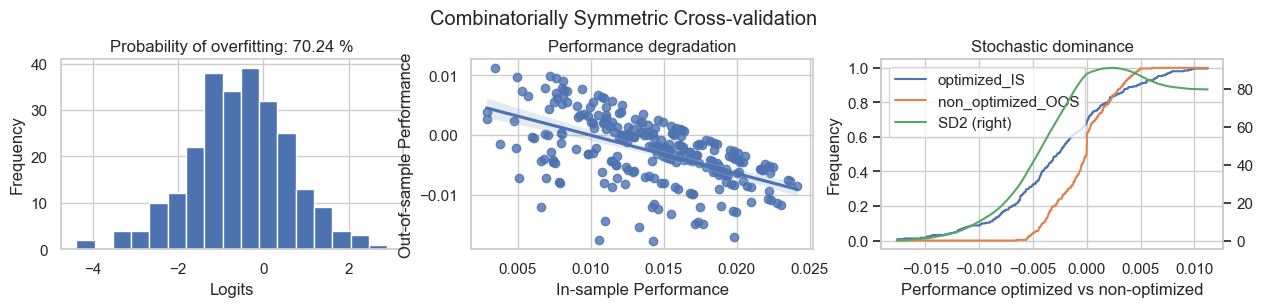

Output()

In [17]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import numpy as np

def get_binance_kline(symbol: str, interval: str, end_time: datetime, total_limit: int = 3000) -> pd.DataFrame:
    base_url = "https://api.binance.com/api/v3/klines"
    all_data = []
    end_timestamp = int(end_time.timestamp() * 1000)
    remaining = total_limit

    while remaining > 0:
        fetch_limit = min(1000, remaining)
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "endTime": end_timestamp,
            "limit": fetch_limit
        }

        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
        except Exception as e:
            print(f"Error fetching data: {e}")
            break

        data = response.json()

        if not data:
            break

        all_data = data + all_data  # prepend chronological
        end_timestamp = data[0][0] - 1
        remaining -= len(data)

    df = pd.DataFrame(all_data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)

    df = df.sort_values("timestamp").reset_index(drop=True)  # 確保時間排序
    df = df.set_index('timestamp')

    return df

ohlcv = get_binance_kline('ETHUSDT','15m',datetime.now(),1000)

@finlab_crypto.Strategy(n1=20, n2=60)
def sma_strategy(ohlcv):
  n1 = sma_strategy.n1
  n2 = sma_strategy.n2
  
  sma1 = ohlcv.close.rolling(int(n1)).mean()
  sma2 = ohlcv.close.rolling(int(n2)).mean()
  return (sma1 > sma2), (sma1 < sma2)
  
import numpy as np
vars = {
  'n1': np.arange(10, 100, 5), 
  'n2': np.arange(10, 100, 5)
}
portfolio = sma_strategy.backtest(ohlcv, vars, freq='15m', plot=True)